# Project 7 - Traffic Sign Detection - EDA

- Course Name :         Applied Machine Learning
- Course instructor:    Sohail Tehranipour
- Student Name :        Afshin Masoudi Ashtiani
- Project 7 :           Traffic Sign Detection
- Date :                September 2024
- Files :               1/4

## Step 1 : Install required libraries



In [1]:
%pip install numpy pandas
%pip install matplotlib seaborn plotly
%pip install opencv-python
%pip install tensorflow keras scikit-learn
%pip install pillow pathlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Step 2 : Import required libraries

In [2]:
# Fundamental classes
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# Performance Plot
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Step 3 : Load datasets (Traffic Signs Images)


- Define required parameters

In [7]:
# Path the data
data_dir = r'C:/Users/Afshin/Desktop/10_Projects/Project_7_Traffic_Sign_Detection/datasets/'
# data_dir = '/content/drive/My Drive/Applied Machine Learning/Project 7 : Traffic Sign Detection/datasets/'
# data_dir = '/kaggle/input/gtsrb-german-traffic-sign/'
train_images_path = data_dir + 'Train'
test_images_path = data_dir + 'Test'
train_csv_path = data_dir + 'Train.csv'
test_csv_path = data_dir + 'Test.csv'

In [9]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [10]:
num_classes = len(os.listdir(data_dir + '/Train/'))
print(f'> Number of classes is {num_classes}.')
img_height, img_width = 50, 50  # Desired image size

> Number of classes is 43.


- Load and prepare the Train and Test datasets

In [11]:
# Importing the dataset
from PIL import Image
from tqdm import tqdm

def load_images_labels_data(path, height, width):
    data = pd.read_csv(path)[['ClassId', 'Path']]
    data['Path'] = data_dir + data['Path']

    labels, images = [], [] 

    # Retreiving the images
    with tf.device('/GPU:0'):
        for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="> Loading images"):
            img_path = row['Path']
            img_label = row['ClassId']
            # Check if the file exists and is a valid image
            if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    image = Image.open(img_path)
                    if image is not None:
                        # Resize the image 
                        image = image.resize((height, width))
                        # Normalize the image to range [0, 1]
                        image = np.array(image) / 255.0  # Normalize pixels
                        images.append(image)
                        labels.append(img_label)
                    else:
                        print(f">> Error reading image: {img_path}")
                except Exception as e:
                    print(f">> Error processing image: {img_path}")
                    print(e)
            else:
                print(f">> Image not found or not a PNG file: {img_path}")

    return np.array(images), np.array(labels), data

In [12]:
train_images, train_labels, train_df = load_images_labels_data(train_csv_path, img_height, img_width)
test_images, test_labels, test_df = load_images_labels_data(test_csv_path, img_height, img_width)
# Checking data shape
print(f'> Shape of Train images: {train_images.shape}')
print(f'> Shape of Test  images: {test_images.shape}')

> Loading images: 100%|██████████| 12630/12630 [01:59<00:00, 105.60it/s]


> Shape of Train images: (39209, 50, 50, 3)
> Shape of Test  images: (12630, 50, 50, 3)


## Step 4 : Exploratory Data Analysis (EDA)

- The Number of Images in Each Class

In [15]:
import pandas as pd
import plotly.express as px

def plot_bar_chart_classes(df: pd.DataFrame, classes: dict, name: str = "Train") -> None:
    # Map class names to class IDs and count occurrences
    df['ClassName'] = df['ClassId'].map(classes)
    count_classes = df['ClassName'].value_counts().sort_values().reset_index()
    count_classes.columns = ['ClassName', 'Number of Images']

    # Create bar chart
    fig = px.bar(
        count_classes,
        x='ClassName',
        y='Number of Images',
        color='Number of Images',
        labels={'Number of Images': 'Number of Images', 'ClassName': 'Classes'},
        title=f"The Number of {name} Images in Each Class"
    )

    fig.show()

In [16]:
plot_bar_chart_classes(train_df, classes, "Train")
plot_bar_chart_classes(test_df, classes, "Test")

- Visualizing random images

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random

def display_random_images(df: pd.DataFrame, rows: int = 5, cols: int = 5) -> None:
    # Ensure the DataFrame has at least enough images to display
    num = rows * cols
    if len(df) < num:
        raise ValueError(f"DataFrame must contain at least {num} images.")

    fig, axs = plt.subplots(rows, cols, figsize=(25, 25))
    axs = axs.flatten()  # Flatten the array for easy indexing

    # Randomly sample without replacement
    sampled_images = df.sample(n=num, random_state=1).reset_index(drop=True)

    for count, (index, row) in enumerate(sampled_images.iterrows()):
        path = row['Path']  # Extracting path
        class_name = row['ClassName']  # Extracting class name

        # Check if the file exists and is a PNG
        if os.path.isfile(path) and path.lower().endswith('.png'):
            try:
                rand_img = imread(path)
                axs[count].imshow(rand_img)
                axs[count].set_title(class_name, fontsize=20)  # Class of image
                axs[count].axis('off')  # Hide axes
            except Exception as e:
                print(f"An error occurred while reading the image: {path}, Error: {str(e)}")
        else:
            print(f"Image not found or not a .png file, path: {path}")

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

>>>> Visualizing 25 random images from Train data <<<<


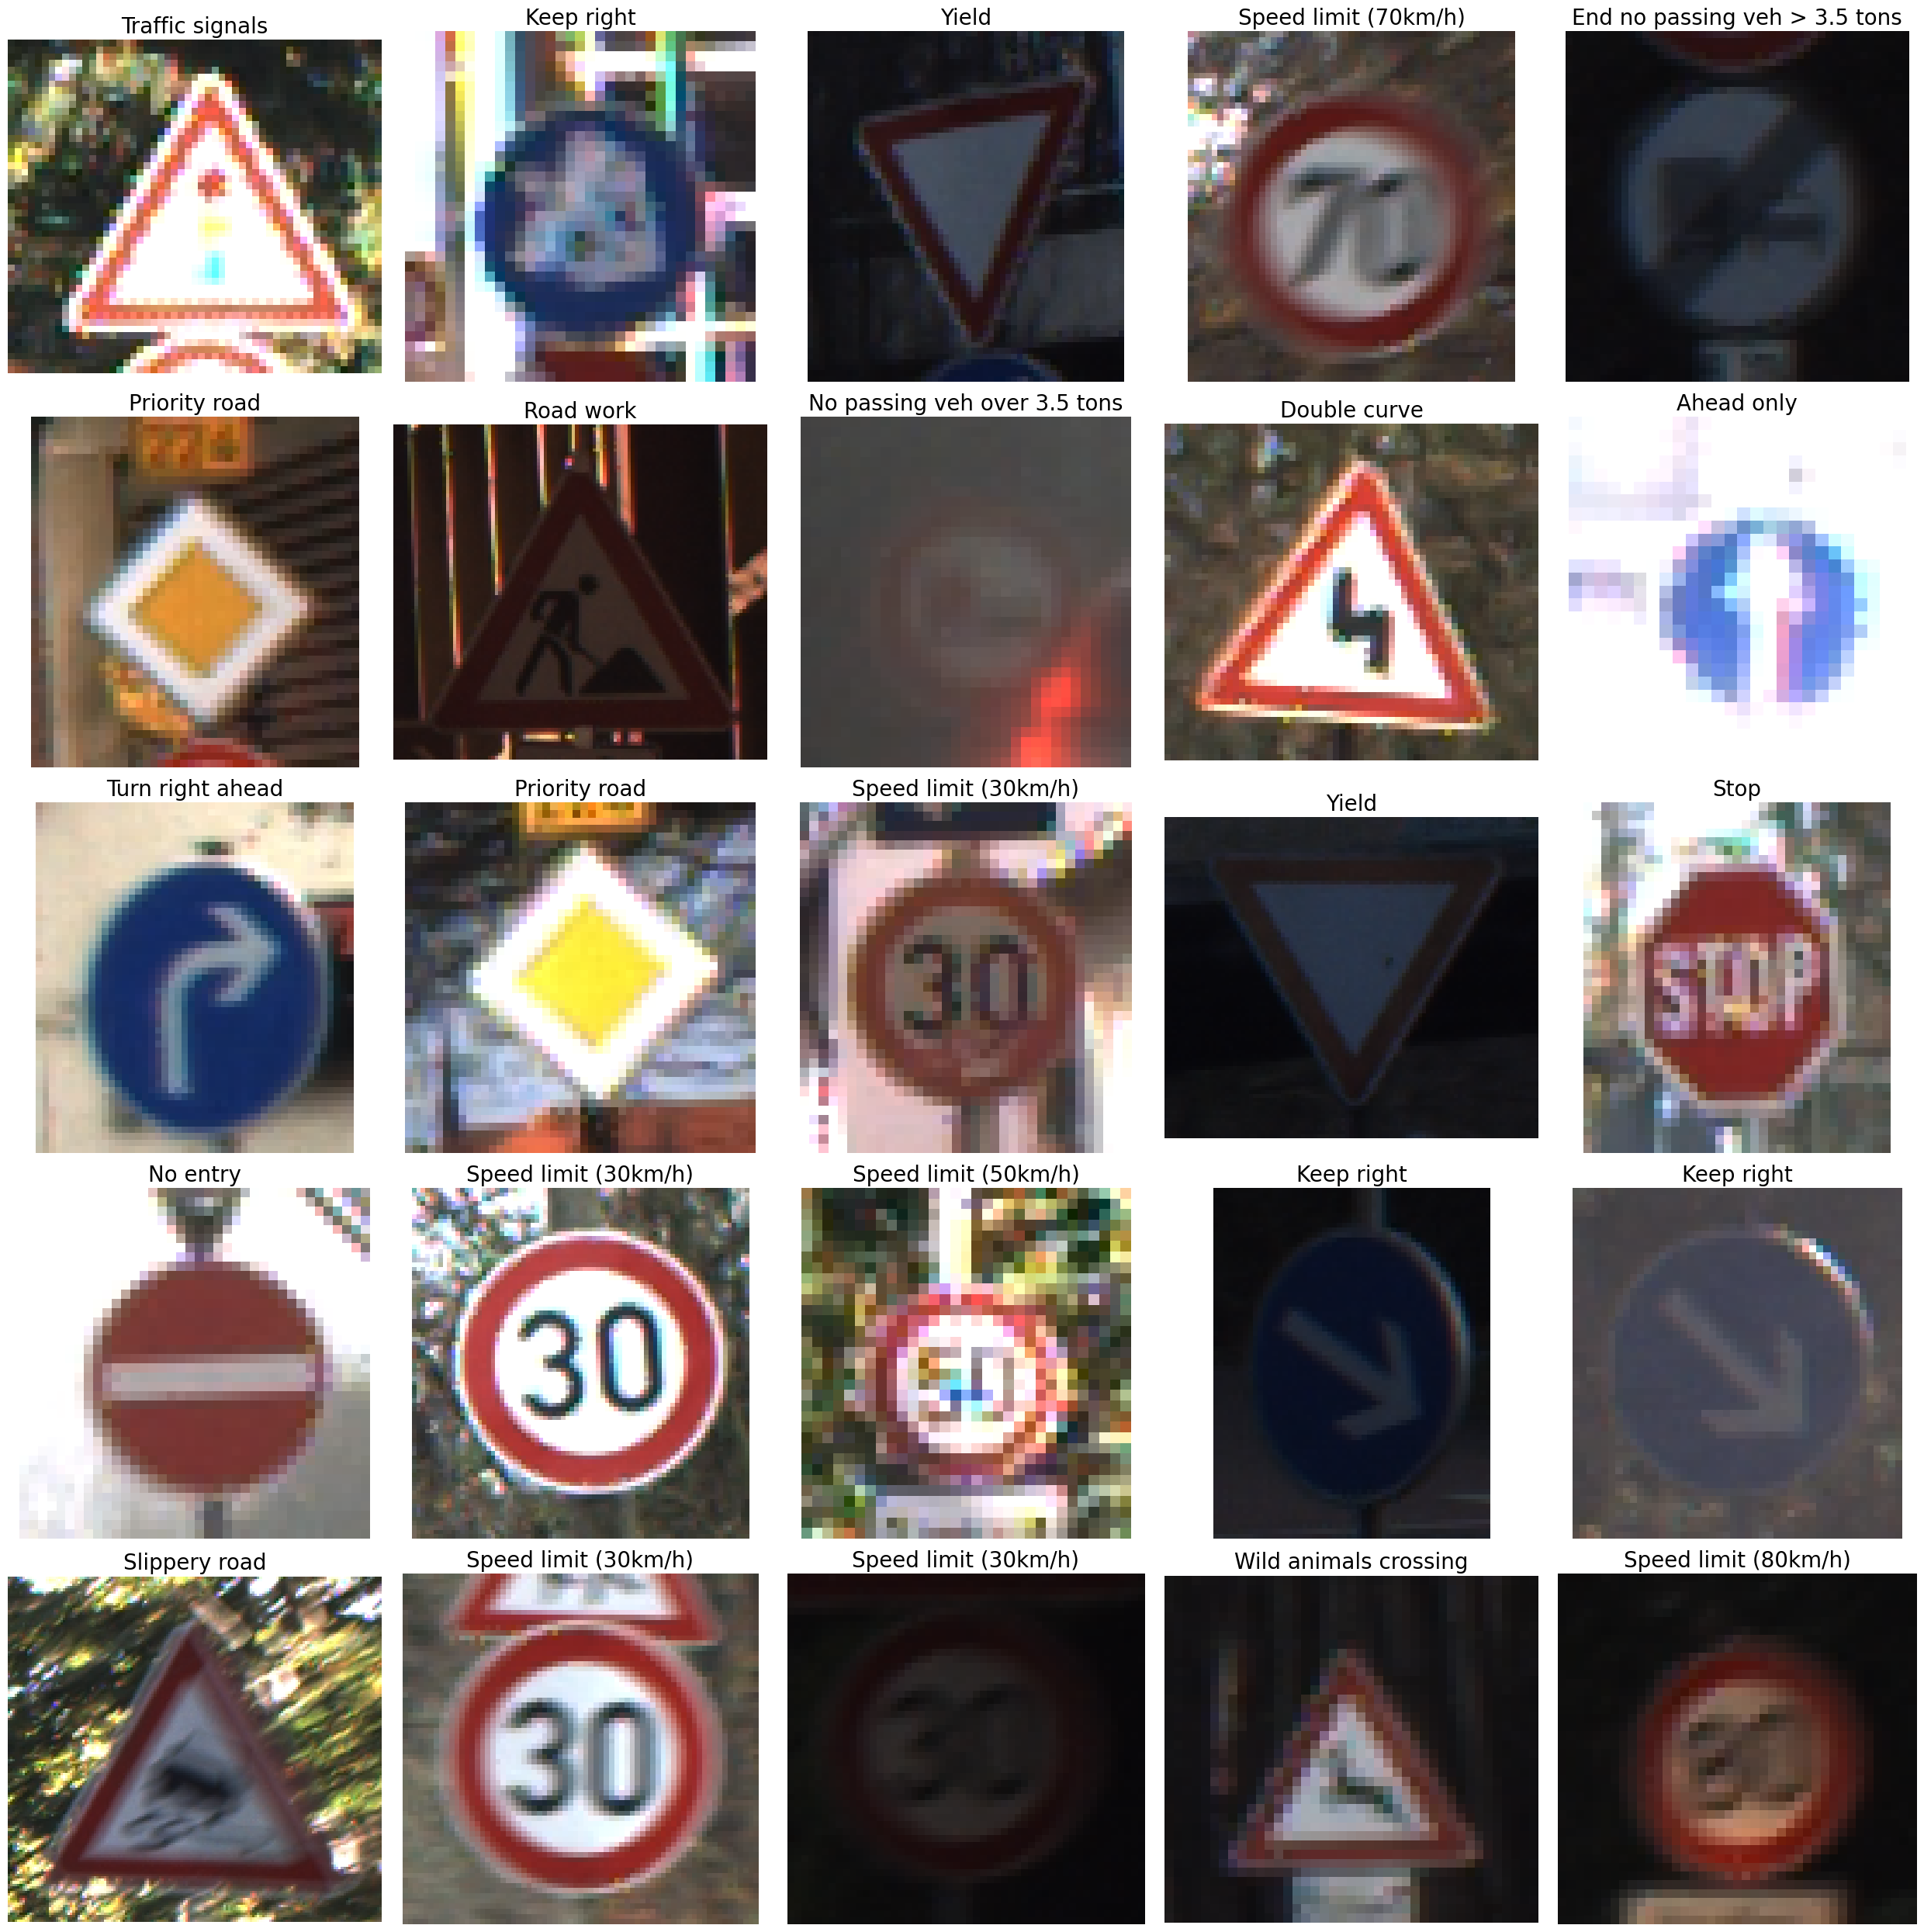

>>>> Visualizing 25 random images from Test data <<<<


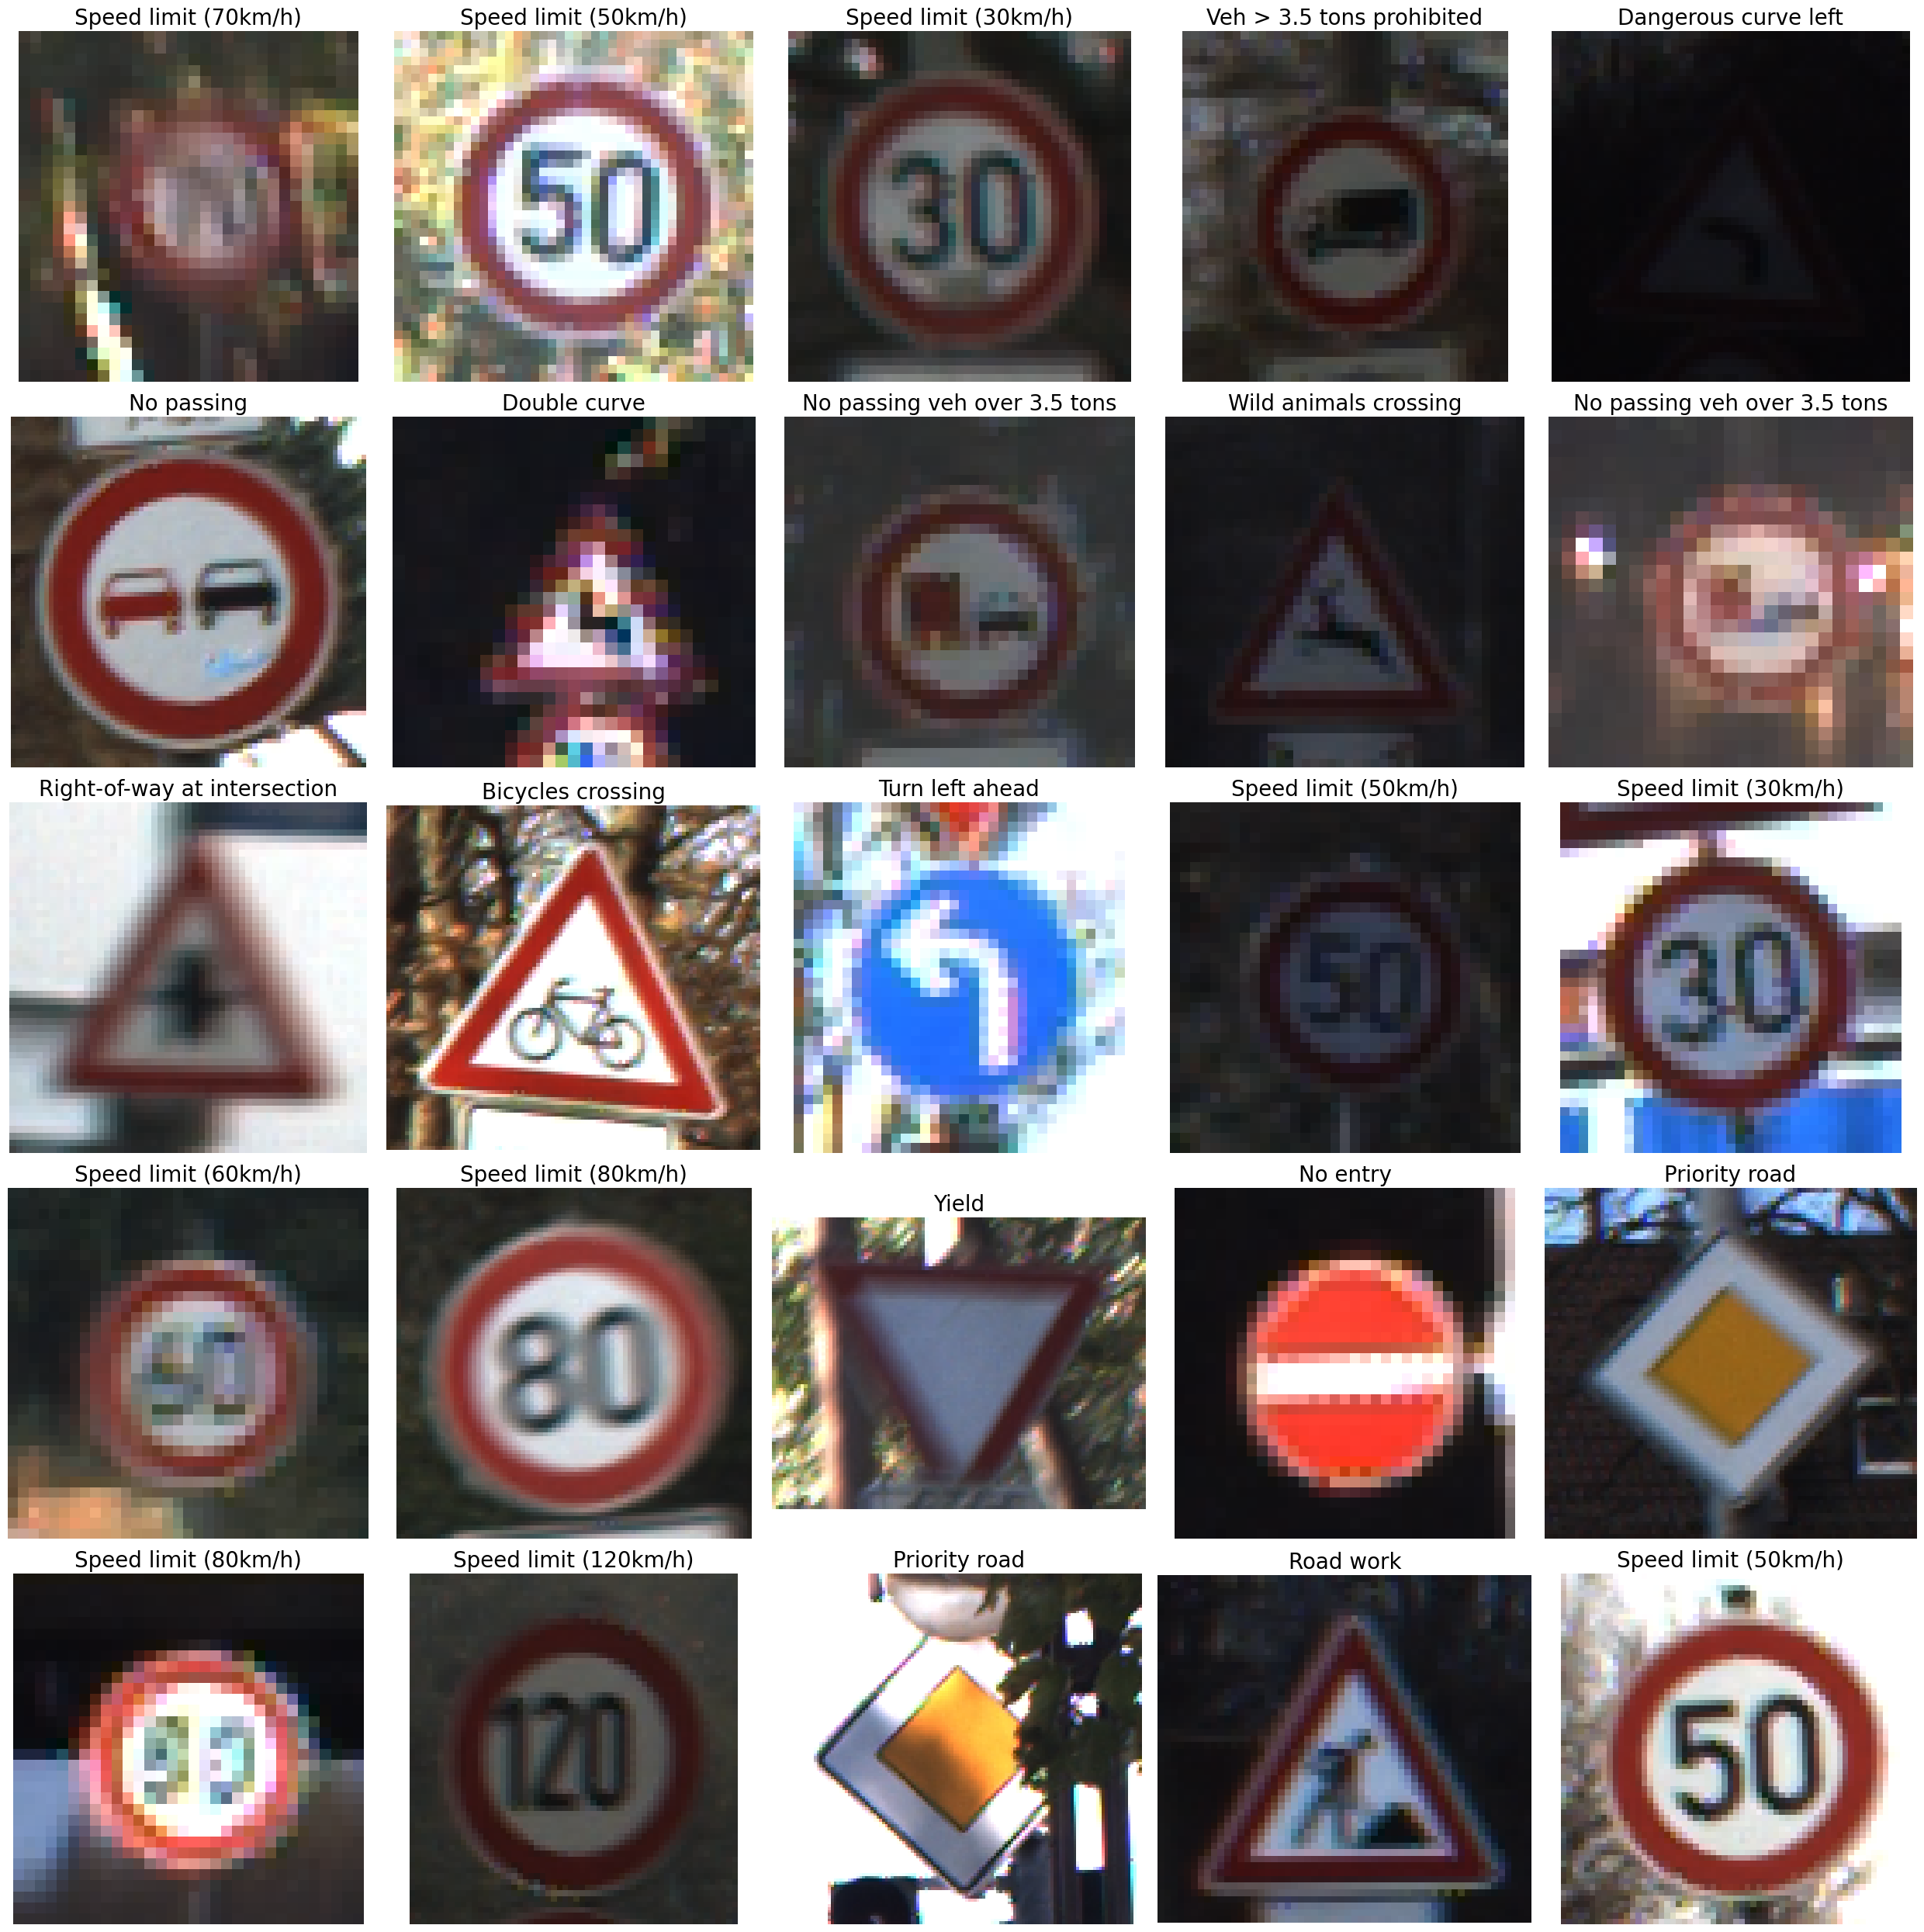

In [22]:
rows, cols = 5, 5
print(f'>>>> Visualizing {rows * cols} random images from Train data <<<<')
display_random_images(train_df, rows, cols)
print(f'>>>> Visualizing {rows * cols} random images from Test data <<<<')
display_random_images(test_df, rows, cols)